# Practical Guide to Calculating EOFs

## Step 1: Data Preparation

Most programming languages have built-in functions to do the covariance, eigenvectors, and eigenvalue calculations for us.  

Our first job is to make sure we set up the data to use these functions correctly.  

Most of the work to calculate EOFs is in the preparation of our data. 

* garbage in = garbage out

* garbage can look like exciting results

Here's what we need to do:

* subset to the region of interest (this is an important choice because the result is highly dependent on the region selected; this is where your climate expertise is important)
* anomalies with no mean or trend
* no missing or extraneous values
* weight the data by cosine of latitude
* re-shaped to be `[time,space]`

#### Import statments

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

#### Read in monthly SST

In [2]:
file='/shared/obs/gridded/OISSTv2/monthly/sst.mnmean.nc'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 461)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-04-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

#### Make anomalies

In [3]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 461)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-04-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 6 7 8 9 10 11 12 1 2 3 4
Data variables:
    sst      (time, lat, lon) float32 7.1525574e-07 ... 7.1525574e-07

#### Shift latitudes

In [4]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

#### Select Tropical Pacific Region

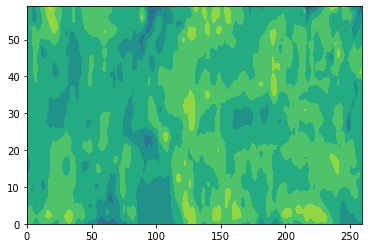

In [5]:
ds_tpac=ds_anoms.sel(lat=slice(-30,30),lon=slice(30,290))
plt.contourf(ds_tpac['sst'][0,:,:])

### No missing or extraneous values

Our data has been "filled" over land with interpolated values not representative of the SSTs. We do not want these values to go into the
calculation of EOFs, but we cannot have missing values in our data when getting the eigenvalues and vectors. 

There is a nice, easy `trick` for addressing this. If we set the land values to zero for all times, they will have no variance and thus will not contribute to the calculation of maximum variance.

#### Read in the land/sea mask

In [6]:
lsfile='/shared/obs/gridded/OISSTv2/lmask/lsmask.nc'
ds_land=xr.open_dataset(lsfile)
ds_land

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

#### Drop time dimension, reverse latitudes, select region

In [7]:
ds_land=ds_land.squeeze()
ds_land=ds_land.reindex(lat=list(reversed(ds_land['lat'])))
ds_land=ds_land.sel(lat=slice(-30,30),lon=slice(30,290))
ds_land

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 260)
Coordinates:
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 286.5 287.5 288.5 289.5
    time     datetime64[ns] 1981-10-29
Data variables:
    mask     (lat, lon) float32 0.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/

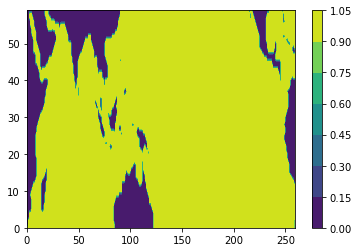

In [8]:
plt.contourf(ds_land['mask'])
plt.colorbar()

#### Set the land values to zero using `xr.where`

In [9]:
tmp=ds_tpac['sst']
#tmp=np.where(ds_land['mask']==1,ds_tpac['sst'],0)

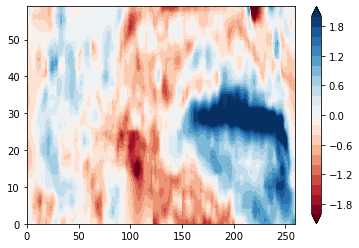

In [10]:
clevs=np.arange(-2,2.2,0.2)
plt.contourf(tmp[10,:,:],clevs,cmap='RdBu',extend='both')
plt.colorbar()

#### Remove the mean and trend

In [11]:
from scipy import signal

In [12]:
#data_detrend=signal.detrend(tmp,0,type='linear')
data_detrend=signal.detrend(tmp,0,type='constant')

In [13]:
data_detrend.shape

(461, 60, 260)

### Weight data 

__Why do we do this?__

Atmosphere and ocean data has higher variance in mid-latitudes than in the tropics. Since we are maximizing variance, we are guaranteed that data closer to the equator will have less variance than data closer to the poles. 

It is common convention to weight our data by the square root of the cosine of the latitude before calculating the EOFs to mitigate this problem.

In [14]:
coslat = np.cos(np.deg2rad(ds_tpac.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
data_detrend=data_detrend*wgts

#### Reshape to `[time,space]`

In [15]:
nx=len(ds_tpac['lon'])
ny=len(ds_tpac['lat'])
nt=len(ds_tpac['time'])

In [16]:
X=np.reshape(data_detrend,((nt,ny*nx)))

In [17]:
X.shape

(461, 15600)

## Step 2: Calculation of EOFs by hand

#### Calculate the Covariance Matrix

In [18]:
C=np.cov(X)
C.shape

(461, 461)

#### Calculate the eigenvalues and vectors of the Covariance Matrix

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

In [19]:
from numpy import linalg as LA

In [20]:
eigenvalues,eigenvectors=LA.eig(C)

You may note that this calculation takes awhile.  We have a very large covariance matrix.  Finding its eigenvalues and eigenvectors is a computationally intensive process. 

After we walk through this `by hand` way of calculating EOFs, we will us a package that does this much more efficiently and effectively for us. 

#### Sort eigenvalues and eigenvectors

In [21]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

#### Get the PC Temporal Patterns

They are just the eigenvectors

In [22]:
PC=eigenvectors
PC.shape

(461, 461)

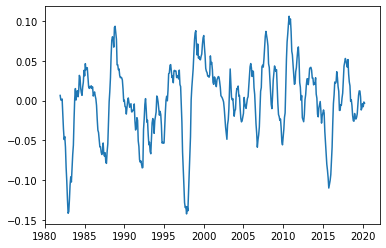

In [23]:
plt.plot(ds_anoms['time'],PC[:,0])

#### Get the EOF Spatial Patterns

In [24]:
EOF=np.dot(X.T,eigenvectors)
EOF=EOF.reshape((ny,nx,nt))
EOF.shape

(60, 260, 461)

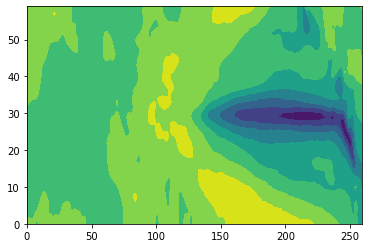

In [25]:
plt.contourf(EOF[:,:,0])

#### Put the land back in

In [26]:
EOF1=np.where(ds_land['mask']==1,EOF[:,:,0],np.nan)

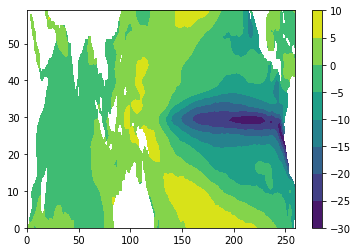

In [27]:
plt.contourf(EOF1[:,:])
plt.colorbar()

#### What are our units?

#### Get the variance explained by each eigenvector

It is the ratio of variance explained by this eigenvector to the total variance

[27.9618906   8.71559432  4.71098146  4.12881141  3.21071242  2.98743252
  2.16777979  2.1213055   1.98974322  1.73559818]


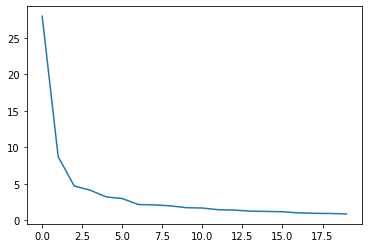

In [39]:
vexp=eigenvalues/np.sum(eigenvalues)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)

## Step 2: Calculation of EOFs by the eofs package

https://ajdawson.github.io/eofs/latest/#

Note that this is an open source package developed by an individual and not highly vetted.  It is not guaranteed to be correct or kept up to date.  But, I have tested it and found it to work correctly for the things I have tried.  

It is designed around how we do EOFs/PCA in climate data analysis, so it is very convenient to use. 

A more vetted, but not designed around the way we do things in our field is https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [29]:
from eofs.xarray import Eof

In [30]:
solver = Eof(ds_tpac['sst'], weights=wgts,center=True)
eof1 = solver.eofsAsCovariance(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

In [31]:
eof1

<xarray.DataArray 'eofs' (mode: 1, lat: 60, lon: 260)>
array([[[-0.00054036,  0.00538778,  0.01187324, ...,  0.27496067,
          0.29348072,  0.2945284 ],
        [ 0.01239979,  0.01297099,  0.01717375, ...,  0.2810373 ,
          0.30137193,  0.3056746 ],
        [ 0.02216924,  0.02290643,  0.02310828, ...,  0.29023358,
          0.3118213 ,  0.33064207],
        ...,
        [-0.05560535, -0.05513429, -0.04153189, ...,  0.07335272,
          0.08684813,  0.08307026],
        [-0.06017369, -0.06030224, -0.05539196, ...,  0.07160988,
          0.07429177,  0.06606004],
        [-0.06862625, -0.06942903, -0.06732738, ...,  0.06841271,
          0.05948411,  0.04579871]]], dtype=float32)
Coordinates:
  * mode     (mode) int64 0
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 286.5 287.5 288.5 289.5
Attributes:
    long_name:  covariance_between_pcs_and_sst

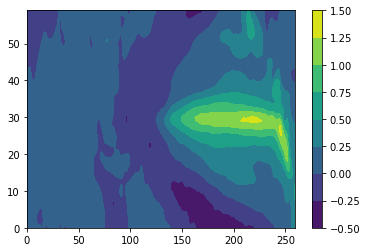

In [32]:
plt.contourf(eof1[0,:,:])
plt.colorbar()

In [33]:
pc1

<xarray.DataArray 'pcs' (time: 461, mode: 1)>
array([[-0.32619542],
       [-0.08564731],
       [-0.21202743],
       [-0.31237832],
       [ 0.01593407],
       [ 0.5149112 ],
       [ 0.7657811 ],
       [ 0.6527508 ],
       [ 0.9016475 ],
       [ 1.3915057 ],
       [ 1.7931473 ],
       [ 2.2592053 ],
       [ 2.746403  ],
       [ 2.7614293 ],
       [ 2.4241283 ],
       [ 1.9547647 ],
       [ 1.6870745 ],
       [ 1.820231  ],
       [ 1.7062293 ],
       [ 1.2823486 ],
...
       [ 0.27004847],
       [ 0.63057953],
       [ 0.8503485 ],
       [ 0.8812897 ],
       [ 0.58480865],
       [ 0.7022975 ],
       [ 0.7468369 ],
       [ 0.7038362 ],
       [ 0.5564803 ],
       [ 0.36460856],
       [ 0.20223777],
       [ 0.10602643],
       [-0.02055946],
       [ 0.34047514],
       [ 0.6431525 ],
       [ 0.7179146 ],
       [ 0.5496042 ],
       [ 0.58662456],
       [ 0.6198833 ],
       [ 0.582904  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-04-01
  * mode     (mode) int64 0
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 6 7 8 9 10 11 12 1 2 3 4

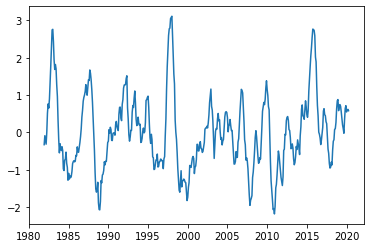

In [34]:
plt.plot(ds_anoms['time'],pc1)

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([28.899607 ,  8.846847 ,  7.7155566,  3.7015927,  3.6620665,
        2.714632 ,  2.6559212,  1.9013971,  1.7774575,  1.5648053],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9

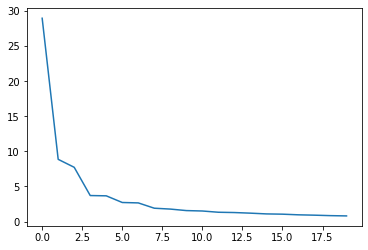

In [38]:
variance_fractions = solver.varianceFraction()
plt.plot(variance_fractions[0:20]*100)
variance_fractions[0:10]*100